# Fraud Detection Model

This notebook focuses on creating a delta file of transactions that are defined as fraud. This dataset is then used to train models to predict whether a transaction is fraudulent.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

In [ ]:
CLE = Path("../data/cleaned")
CUR = Path("../data/curated")

In [3]:
tx = pd.read_parquet(CUR / "all_given_data.parquet")
consumer_fraud = pd.read_parquet(CLE / "consumer_fraud.parquet")
merchant_fraud = pd.read_parquet(CLE / "merchant_fraud.parquet")

## Define rules that identify transactions as fraud

| Rule                                                                                                  | Rationale                                                                            |
| ----------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------ |
| **Burst Transactions** <br> More than 5 transactions within 1 hour by the same consumer               | Rapid repeat purchases can indicate account takeover or bot abuse.                   |
| **Low-History, High-Spend** <br> `transaction_count <= 1` and `dollar_value > P90`                      | A new customer making a large first purchase is higher risk.                         |
| **High Weighted Fraud Probability** <br> `consumer_fraud_prob > 0.7` or `merchant_fraud_prob > 0.7`   | Use existing scores to flag risky actors.                                |
| **High-Risk Merchants** <br> `order_count < 10` and `total_sales > P90`   | A new merchant that is already having extremely high revenue with little orders is risky. |


## Create Delta File

In [4]:
# Merge consumer fraud probability onto transactions
tx_fraud = tx.merge(
    consumer_fraud[["user_id", "order_datetime", "tx_fraud_consumer"]],
    on=["user_id", "order_datetime"],
    how="left"
)

# Replace NaN with 0 and rename
tx_fraud["tx_fraud_consumer"] = tx_fraud["tx_fraud_consumer"].fillna(0)

print(tx_fraud[["user_id", "order_datetime", "tx_fraud_consumer"]].head())

  user_id order_datetime  tx_fraud_consumer
0       1     2021-02-28                0.0
1   18485     2021-02-28                0.0
2       1     2021-02-28                0.0
3   18488     2021-02-28                0.0
4       2     2021-02-28                0.0


In [5]:
# Merge consumer fraud probability onto transactions
tx_full = tx_fraud.merge(
    merchant_fraud[["merchant_abn", "order_datetime", "tx_fraud_merchant"]],
    on=["merchant_abn", "order_datetime"],
    how="left"
)

# Replace NaN with 0 and rename
tx_full["tx_fraud_merchant"] = tx_full["tx_fraud_merchant"].fillna(0)

print(tx_full[["user_id", "order_datetime", "tx_fraud_merchant"]].head())

  user_id order_datetime  tx_fraud_merchant
0       1     2021-02-28                0.0
1   18485     2021-02-28                0.0
2       1     2021-02-28                0.0
3   18488     2021-02-28                0.0
4       2     2021-02-28                0.0


In [6]:
tx_full.columns

Index(['user_id', 'merchant_abn', 'dollar_value', 'order_id', 'order_datetime',
       'consumer_id', 'transaction_count', 'total_spend', 'unique_merchants',
       'avg_spend', 'consumer_fraud_prob_avg', 'consumer_name', 'address',
       'state', 'postcode', 'gender', 'SA2_code', 'SA2_name', 'is_po_box',
       'merchant_name', 'tags', 'categories', 'type', 'take_rate',
       'order_count', 'total_sales', 'avg_order_value', 'unique_consumers',
       'repeat_consumers', 'repurchase_rate', 'tx_fraud_consumer',
       'tx_fraud_merchant'],
      dtype='object')

In [7]:
# Datetime + sort (for the burst rule)
tx_full["order_datetime"] = pd.to_datetime(tx_full["order_datetime"], errors="coerce")
tx_full = tx_full.sort_values(["user_id", "order_datetime"]).reset_index(drop=True)

# Rolling count of a user's purchases in the past hour
def _rolling_1h_count(g: pd.DataFrame) -> pd.Series:
    g = g.set_index("order_datetime")
    out = g["order_id"].rolling("1h").count()
    return out.reset_index(drop=True)

tx_full["n_txn_1h"] = (
    tx_full.groupby("user_id", group_keys=False)
           .apply(_rolling_1h_count)
           .reset_index(drop=True)
)

# Thresholds used by rules
p90_value = float(tx_full["dollar_value"].quantile(0.90))

# for the “High-Risk Merchants” rule we’ll use total revenue
p90_revenue = float(tx_full["total_sales"].quantile(0.90))

/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_12693/4109129319.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_rolling_1h_count)


In [8]:
# Apply individual rules

# Burst Transactions: > 5 txs within 1 hour for the same consumer
rule_burst = tx_full["n_txn_1h"] > 5

# Low-History, High-Spend: first/only customer txn and value > P90
rule_low_hist_high_spend = (tx_full["transaction_count"] <= 1) & (tx_full["dollar_value"] > p90_value)

# High Fraud Probability
rule_high_fraud_prob = (tx_full["tx_fraud_consumer"] > 0.70) | (tx_full["tx_fraud_merchant"] > 0.70)

# High-Risk Merchants: few orders overall, but very high revenue
rule_high_risk_merch = (tx_full["order_count"] < 10) & (tx_full["total_sales"] > p90_revenue)

# Combine the rules to create boolean flag
tx_full["is_fraud"] = (
    rule_burst
    | rule_low_hist_high_spend
    | rule_high_fraud_prob
    | rule_high_risk_merch
)

pct_fraud = int(tx_full["is_fraud"].sum()) / len(tx_full) * 100

print("Fraud flags:", int(tx_full["is_fraud"].sum()), "/", len(tx_full))
print("% of flagged tx:", pct_fraud)
print("P90 dollar_value:", round(p90_value, 2))
print("P90 of total_sales:", round(p90_revenue, 2))

Fraud flags: 13280 / 13614850
% of flagged tx: 0.09754055314601337
P90 dollar_value: 351.92
P90 of total_sales: 8908822.66


In [9]:
# Delta file = just the flagged order_ids
fraud_delta = tx_full.loc[tx_full["is_fraud"], ["order_id"]].copy()
fraud_delta["is_fraud"] = True

In [10]:
# Save
fraud_delta.to_parquet(CUR / "fraud_delta.parquet", index=False)

## Check Distributions


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


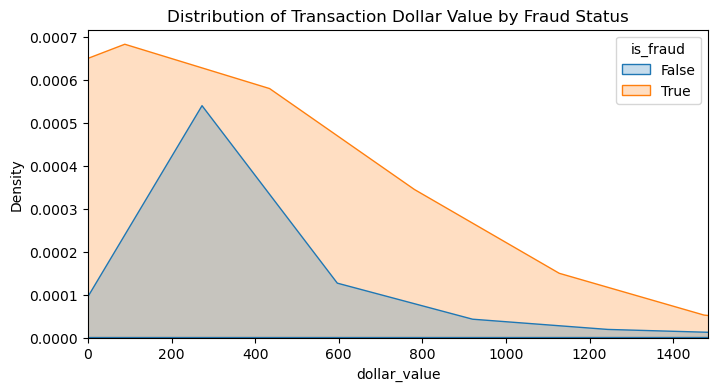

In [12]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data=tx_full, x="dollar_value", hue="is_fraud", common_norm=False, fill=True)
plt.title("Distribution of Transaction Dollar Value by Fraud Status")
plt.xlim(0, tx_full["dollar_value"].quantile(0.99))  # zoom in, ignore extreme outliers
plt.show()

/var/folders/mt/_r39z94x2mv2hjn950c58jp40000gn/T/ipykernel_12693/3930202397.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_consumer_activity = tx_full.groupby(consumer_groups)["is_fraud"].mean()


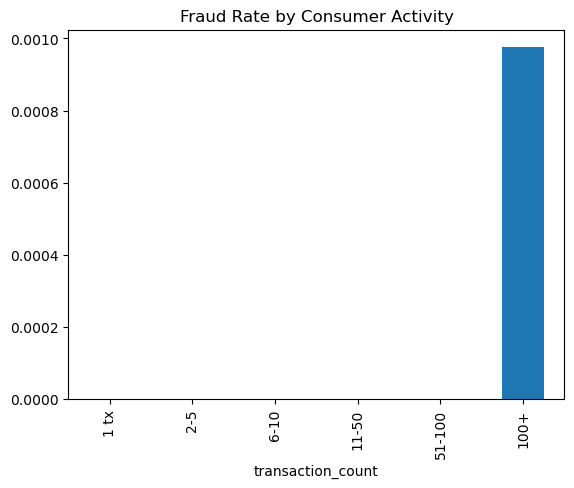

In [13]:
consumer_groups = pd.cut(
    tx_full["transaction_count"],
    bins=[0, 1, 5, 10, 50, 100, tx_full["transaction_count"].max()],
    labels=["1 tx","2-5","6-10","11-50","51-100","100+"]
)

fraud_by_consumer_activity = tx_full.groupby(consumer_groups)["is_fraud"].mean()
fraud_by_consumer_activity.plot(kind="bar", title="Fraud Rate by Consumer Activity")
plt.show()


### Summary of Insights for Delta Rules

Our rule-based fraud detection framework is directly motivated by the observed transaction and consumer behavior patterns:
1. Burst Transactions

The distribution of transaction values shows an extremely skewed pattern, with most transactions concentrated at the lower dollar range but a small set of rapid repeat transactions occurring at high values. This validates the rule to flag more than 5 transactions in 1 hour by the same consumer, as such bursts deviate sharply from normal consumer behavior and are strong indicators of account takeover or bot-driven fraud.

2. Low-History, High-Spend Consumers

The density plot highlights that fraudulent transactions disproportionately occur at higher dollar values, particularly when consumer history (transaction count) is limited. This supports the rule transaction_count <= 1 and dollar_value > P90, as first-time buyers making unusually large purchases are riskier compared to repeat, low-value customers.

3. High Weighted Fraud Probability

Incorporating both consumer-level and merchant-level fraud probabilities ensures the model leverages historical risk indicators. The strong overlap of fraudulent distributions across dollar values justifies using probabilistic signals (consumer_fraud_prob > 0.7 or merchant_fraud_prob > 0.7) to capture risks that transaction-level features alone may miss.

4. High-Risk Merchants

The fraud rate by consumer activity shows that merchants with relatively few orders (low order_count) but abnormally high total revenue are outliers. The rule order_count < 10 and total_sales > P90 captures these cases where merchants may artificially inflate revenue or attract high-value but fraudulent customers.

### Overall Insight:
The delta rules effectively complement the statistical distributions observed in the data. By capturing rare but high-risk behaviors (burst activity, high spend with low history, outlier merchants), the rules filter out patterns not well explained by normal consumer activity. This layered approach balances both interpretability and fraud coverage, giving the BNPL firm an actionable fraud-screening mechanism.